In [1]:
# !pip install accelerate
# !pip install sentencepiece

In [2]:
import torch
import torch.nn.functional as F
from transformers import LlamaTokenizer, LlamaForCausalLM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
from typing import Dict, List, Tuple, Optional
import json


C:\Users\hskay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_1_PATH = "meta-llama/Llama-2-7b-chat-hf" 
MODEL_2_PATH = "meta-llama/Llama-2-7b-hf"       

DEVICE

device(type='cuda')

In [4]:
DEVICE = torch.device('cpu')

DEVICE

device(type='cpu')

In [5]:
tokenizer = LlamaTokenizer.from_pretrained(MODEL_1_PATH)
tokenizer.pad_token = tokenizer.eos_token

model_1 = LlamaForCausalLM.from_pretrained(
    MODEL_1_PATH,
    torch_dtype=torch.float32, 
    device_map=DEVICE
)

model_2 = LlamaForCausalLM.from_pretrained(
    MODEL_2_PATH,
    torch_dtype=torch.float32, 
    device_map=DEVICE
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:35<00:00, 17.71s/it]


In [6]:
DEVICE

device(type='cpu')

In [7]:
model_1 = model_1.to(DEVICE)
model_2 = model_2.to(DEVICE)

In [8]:
def get_model_weights(model, move_to_cpu=False,layer_range=None):
    weights = {}
    
    # Embedding weights
    embed_weight = model.model.embed_tokens.weight
    weights['embed_tokens'] = embed_weight.detach().cpu() if move_to_cpu else embed_weight.detach()
    
    # Layer-specific weights
    if layer_range is None:
        layer_range = range(len(model.model.layers))
    
    for i in layer_range:
        if i >= len(model.model.layers):
            continue
            
        layer = model.model.layers[i]
        layer_prefix = f"layer_{i}"
        
        # Self-attention weights
        weights[f"{layer_prefix}_q_proj"] = layer.self_attn.q_proj.weight.detach().cpu() if move_to_cpu else layer.self_attn.q_proj.weight.detach()
        weights[f"{layer_prefix}_k_proj"] = layer.self_attn.k_proj.weight.detach().cpu() if move_to_cpu else layer.self_attn.k_proj.weight.detach()
        weights[f"{layer_prefix}_v_proj"] = layer.self_attn.v_proj.weight.detach().cpu() if move_to_cpu else layer.self_attn.v_proj.weight.detach()
        weights[f"{layer_prefix}_o_proj"] = layer.self_attn.o_proj.weight.detach().cpu() if move_to_cpu else layer.self_attn.o_proj.weight.detach()
        
        # MLP weights
        weights[f"{layer_prefix}_gate_proj"] = layer.mlp.gate_proj.weight.detach().cpu() if move_to_cpu else layer.mlp.gate_proj.weight.detach()
        weights[f"{layer_prefix}_up_proj"] = layer.mlp.up_proj.weight.detach().cpu() if move_to_cpu else layer.mlp.up_proj.weight.detach()
        weights[f"{layer_prefix}_down_proj"] = layer.mlp.down_proj.weight.detach().cpu() if move_to_cpu else layer.mlp.down_proj.weight.detach()
        
        # Layer norm weights
        weights[f"{layer_prefix}_input_layernorm"] = layer.input_layernorm.weight.detach().cpu() if move_to_cpu else layer.input_layernorm.weight.detach()
        weights[f"{layer_prefix}_post_attention_layernorm"] = layer.post_attention_layernorm.weight.detach().cpu() if move_to_cpu else layer.post_attention_layernorm.weight.detach()
    
    # Final layer norm and LM head
    weights['final_norm'] = model.model.norm.weight.detach().cpu() if move_to_cpu else model.model.norm.weight.detach()
    weights['lm_head'] = model.lm_head.weight.detach().cpu() if move_to_cpu else model.lm_head.weight.detach()
    
    return weights

def calculate_weight_differences(weights_1, weights_2):
    differences = {}
    
    common_keys = set(weights_1.keys()) & set(weights_2.keys())
    print(f"Comparing {len(common_keys)} weight matrices...")
    
    for i, key in enumerate(common_keys):
        if i % 10 == 0:
            print(f"Processing {i+1}/{len(common_keys)}: {key}")
            
        w1 = weights_1[key]
        w2 = weights_2[key]
        
        if w1.shape != w2.shape:
            print(f"Warning: Shape mismatch for {key}: {w1.shape} vs {w2.shape}")
            continue
        
        # Calculate difference matrix
        diff_matrix = w1 - w2
        
        # Calculate various norms and statistics
        frobenius_norm = torch.norm(diff_matrix, p='fro').item()
        frobenius_norm_relative = frobenius_norm / (torch.norm(w1, p='fro').item() + 1e-10)
        
        spectral_norm = torch.norm(diff_matrix, p=2).item()
        spectral_norm_relative = spectral_norm / (torch.norm(w1, p=2).item() + 1e-10)
        
        # Element-wise statistics
        abs_diff = torch.abs(diff_matrix)
        mean_abs_diff = torch.mean(abs_diff).item()
        max_abs_diff = torch.max(abs_diff).item()
        std_diff = torch.std(diff_matrix).item()
        
        # Percentage of significantly different weights (threshold = 1e-6)
        significant_diff_ratio = (abs_diff > 1e-6).float().mean().item()
        
        # Cosine similarity
        w1_flat = w1.flatten()
        w2_flat = w2.flatten()
        cosine_sim = F.cosine_similarity(w1_flat.unsqueeze(0), w2_flat.unsqueeze(0)).item()
        
        differences[key] = {
            'frobenius_norm': frobenius_norm,
            'frobenius_norm_relative': frobenius_norm_relative,
            'spectral_norm': spectral_norm,
            'spectral_norm_relative': spectral_norm_relative,
            'mean_abs_difference': mean_abs_diff,
            'max_abs_difference': max_abs_diff,
            'std_difference': std_diff,
            'significant_diff_ratio': significant_diff_ratio,
            'cosine_similarity': cosine_sim,
            'weight_shape': w1.shape,
            'total_parameters': w1.numel()
        }
    
    return differences

def analyze_weight_patterns(weight_differences):
    analysis = {
        'by_component_type': defaultdict(list),
        'by_layer_depth': defaultdict(list),
        'summary_stats': {}
    }
    
    # Group by component type
    for layer_name, diff_data in weight_differences.items():
        if any(x in layer_name for x in ['q_proj', 'k_proj', 'v_proj', 'o_proj']):
            component_type = 'attention'
        elif any(x in layer_name for x in ['gate_proj', 'up_proj', 'down_proj']):
            component_type = 'mlp'
        elif 'layernorm' in layer_name or 'norm' in layer_name:
            component_type = 'normalization'
        elif 'embed' in layer_name:
            component_type = 'embedding'
        elif 'lm_head' in layer_name:
            component_type = 'output'
        else:
            component_type = 'other'
        
        analysis['by_component_type'][component_type].append({
            'layer_name': layer_name,
            'frobenius_norm': diff_data['frobenius_norm'],
            'frobenius_norm_relative': diff_data['frobenius_norm_relative'],
            'significant_diff_ratio': diff_data['significant_diff_ratio'],
            'cosine_similarity': diff_data['cosine_similarity']
        })
    
    # Group by layer depth
    for layer_name, diff_data in weight_differences.items():
        if 'layer_' in layer_name:
            try:
                layer_num = int(layer_name.split('_')[1])
                analysis['by_layer_depth'][layer_num].append({
                    'layer_name': layer_name,
                    'frobenius_norm': diff_data['frobenius_norm'],
                    'frobenius_norm_relative': diff_data['frobenius_norm_relative'],
                    'cosine_similarity': diff_data['cosine_similarity']
                })
            except:
                continue
    
    # Calculate summary statistics
    all_frobenius = [data['frobenius_norm'] for data in weight_differences.values()]
    all_frobenius_rel = [data['frobenius_norm_relative'] for data in weight_differences.values()]
    all_significant_ratios = [data['significant_diff_ratio'] for data in weight_differences.values()]
    all_cosine_sims = [data['cosine_similarity'] for data in weight_differences.values()]
    
    analysis['summary_stats'] = {
        'total_layers_compared': len(weight_differences),
        'mean_frobenius_norm': np.mean(all_frobenius),
        'std_frobenius_norm': np.std(all_frobenius),
        'max_frobenius_norm': np.max(all_frobenius),
        'min_frobenius_norm': np.min(all_frobenius),
        'mean_frobenius_norm_relative': np.mean(all_frobenius_rel),
        'mean_significant_diff_ratio': np.mean(all_significant_ratios),
        'mean_cosine_similarity': np.mean(all_cosine_sims),
        'min_cosine_similarity': np.min(all_cosine_sims),
        'total_parameters_compared': sum(data['total_parameters'] for data in weight_differences.values())
    }
    
    return analysis

def print_weight_analysis_summary(analysis):
    print("="*70)
    print("LLAMA MODEL WEIGHT DIFFERENCE ANALYSIS SUMMARY")
    print("="*70)
    
    # Overall statistics
    stats = analysis['summary_stats']
    print(f"\n📊 OVERALL STATISTICS:")
    print(f"  • Total layers compared: {stats['total_layers_compared']}")
    print(f"  • Total parameters compared: {stats['total_parameters_compared']:,}")
    print(f"  • Mean Frobenius norm: {stats['mean_frobenius_norm']:.2e}")
    print(f"  • Mean relative Frobenius norm: {stats['mean_frobenius_norm_relative']:.8f}")
    print(f"  • Max Frobenius norm: {stats['max_frobenius_norm']:.2e}")
    print(f"  • Min Frobenius norm: {stats['min_frobenius_norm']:.2e}")
    print(f"  • Mean cosine similarity: {stats['mean_cosine_similarity']:.8f}")
    print(f"  • Min cosine similarity: {stats['min_cosine_similarity']:.8f}")
    print(f"  • Mean significant difference ratio: {stats['mean_significant_diff_ratio']:.4f}")
    
    # Component type analysis
    print(f"\n🔧 BY COMPONENT TYPE:")
    for comp_type, comp_data in analysis['by_component_type'].items():
        frob_norms = [item['frobenius_norm_relative'] for item in comp_data]
        cosine_sims = [item['cosine_similarity'] for item in comp_data]
        sig_ratios = [item['significant_diff_ratio'] for item in comp_data]
        
        print(f"  {comp_type.upper()}:")
        print(f"    - Count: {len(comp_data)} layers")
        print(f"    - Mean relative Frobenius: {np.mean(frob_norms):.8f} ± {np.std(frob_norms):.8f}")
        print(f"    - Mean cosine similarity: {np.mean(cosine_sims):.8f} ± {np.std(cosine_sims):.8f}")
        print(f"    - Mean sig. diff ratio: {np.mean(sig_ratios):.4f}")
    
    # Layer depth analysis (if available)
    if analysis['by_layer_depth']:
        print(f"\n📈 BY LAYER DEPTH:")
        for depth in sorted(analysis['by_layer_depth'].keys())[:10]:  # Show first 10 layers
            depth_data = analysis['by_layer_depth'][depth]
            frob_norms = [item['frobenius_norm_relative'] for item in depth_data]
            cosine_sims = [item['cosine_similarity'] for item in depth_data]
            
            print(f"  Layer {depth}: Frob={np.mean(frob_norms):.6f}, Cosine={np.mean(cosine_sims):.6f}")
    
    print("="*70)

In [9]:
weights_1 = get_model_weights(model_1)
weights_2 = get_model_weights(model_2)

In [10]:
weight_differences = calculate_weight_differences(weights_1, weights_2)

Comparing 291 weight matrices...
Processing 1/291: layer_26_k_proj
Processing 11/291: embed_tokens
Processing 21/291: layer_0_o_proj
Processing 31/291: layer_11_v_proj
Processing 41/291: layer_20_v_proj
Processing 51/291: layer_29_k_proj
Processing 61/291: layer_23_gate_proj
Processing 71/291: layer_3_o_proj
Processing 81/291: layer_12_q_proj
Processing 91/291: layer_17_o_proj
Processing 101/291: layer_15_input_layernorm
Processing 111/291: layer_16_q_proj
Processing 121/291: layer_26_v_proj
Processing 131/291: layer_6_down_proj
Processing 141/291: layer_31_gate_proj
Processing 151/291: layer_10_input_layernorm
Processing 161/291: layer_17_post_attention_layernorm
Processing 171/291: layer_6_k_proj
Processing 181/291: layer_29_input_layernorm
Processing 191/291: layer_21_gate_proj
Processing 201/291: layer_14_k_proj
Processing 211/291: layer_28_down_proj
Processing 221/291: layer_9_gate_proj
Processing 231/291: layer_15_post_attention_layernorm
Processing 241/291: layer_26_gate_proj
Pr

In [11]:
analysis = analyze_weight_patterns(weight_differences)

In [12]:
print_weight_analysis_summary(analysis)

LLAMA MODEL WEIGHT DIFFERENCE ANALYSIS SUMMARY

📊 OVERALL STATISTICS:
  • Total layers compared: 291
  • Total parameters compared: 6,738,415,616
  • Mean Frobenius norm: 5.00e+00
  • Mean relative Frobenius norm: 0.05240598
  • Max Frobenius norm: 2.33e+01
  • Min Frobenius norm: 6.37e-02
  • Mean cosine similarity: 1.00115807
  • Min cosine similarity: 0.99230218
  • Mean significant difference ratio: 0.9642

🔧 BY COMPONENT TYPE:
  ATTENTION:
    - Count: 128 layers
    - Mean relative Frobenius: 0.06287519 ± 0.01413015
    - Mean cosine similarity: 0.99922307 ± 0.00117901
    - Mean sig. diff ratio: 0.9713
  MLP:
    - Count: 96 layers
    - Mean relative Frobenius: 0.06610288 ± 0.00257659
    - Mean cosine similarity: 1.00398319 ± 0.00041742
    - Mean sig. diff ratio: 0.9729
  NORMALIZATION:
    - Count: 65 layers
    - Mean relative Frobenius: 0.01038052 ± 0.00265356
    - Mean cosine similarity: 0.99998514 ± 0.00004352
    - Mean sig. diff ratio: 0.9371
  EMBEDDING:
    - Count:

In [13]:
weight_differences

{'layer_26_k_proj': {'frobenius_norm': 5.332941055297852,
  'frobenius_norm_relative': 0.05988596209850361,
  'spectral_norm': 5.332941055297852,
  'spectral_norm_relative': 0.05988596209850361,
  'mean_abs_difference': 0.0010347208008170128,
  'max_abs_difference': 0.009765625,
  'std_difference': 0.001302430871874094,
  'significant_diff_ratio': 0.9711325764656067,
  'cosine_similarity': 0.9996031522750854,
  'weight_shape': torch.Size([4096, 4096]),
  'total_parameters': 16777216},
 'layer_22_down_proj': {'frobenius_norm': 8.437965393066406,
  'frobenius_norm_relative': 0.06938864292926306,
  'spectral_norm': 8.437965393066406,
  'spectral_norm_relative': 0.06938864292926306,
  'mean_abs_difference': 0.0010020476765930653,
  'max_abs_difference': 0.0078125,
  'std_difference': 0.0012579604517668486,
  'significant_diff_ratio': 0.9741316437721252,
  'cosine_similarity': 1.0036357641220093,
  'weight_shape': torch.Size([4096, 11008]),
  'total_parameters': 45088768},
 'layer_12_up_pro

In [14]:
for i in weight_differences:
    print(weight_differences[i]['mean_abs_difference'])

0.0010347208008170128
0.0010020476765930653
0.0009561135084368289
0.004318595863878727
0.0009610253619030118
0.0009050709777511656
0.0010352940298616886
0.004114169627428055
0.0010895447339862585
0.0010182401165366173
0.0007397193694487214
0.0008480151882395148
0.0008508003666065633
0.0009455127292312682
0.004119643941521645
0.0010375857818871737
0.0009281010716222227
0.002398568904027343
0.0009909870568662882
0.0007258172845467925
0.0007826546207070351
0.0016280289273709059
0.0010239921975880861
0.004676243755966425
0.0009837074903771281
0.004198194481432438
0.001902759075164795
0.0008623851463198662
0.0010321848094463348
0.0024023056030273438
0.0008401564555242658
0.0008602877496741712
0.0009188769618049264
0.0010338914580643177
0.0010316901607438922
0.0008643656619824469
0.0010129038710147142
0.0010217539966106415
0.0009594949660822749
0.0010643609566614032
0.0009192785946652293
0.0016783475875854492
0.000740374147426337
0.00092760642291978
0.0008473646594211459
0.003545761108398437

In [15]:
activations_model_1 = {}
activations_model_2 = {}
current_hooks = []

In [16]:
def clear_activations():
    global activations_model_1, activations_model_2
    activations_model_1.clear()
    activations_model_2.clear()

def remove_all_hooks():
    global current_hooks
    for hook in current_hooks:
        hook.remove()
    current_hooks.clear()

def get_activation_hook(name, model_name):
    def hook(module, input, output):
        try:
            # Handle output
            if isinstance(output, tuple):
                activation = output[0] if output[0] is not None else None
            else:
                activation = output
            
            # Handle input - check for None values
            input_tensor = None
            if input is not None:
                if isinstance(input, tuple) and len(input) > 0:
                    input_tensor = input[0] if input[0] is not None else None
                else:
                    input_tensor = input if input is not None else None
            
            # Create activation data with None checks
            activation_data = {
                'output': activation.detach().cpu() if activation is not None else None,
                'input': input_tensor.detach().cpu() if input_tensor is not None else None,
                'weight': module.weight.detach().cpu() if hasattr(module, 'weight') and module.weight is not None else None,
                'bias': module.bias.detach().cpu() if hasattr(module, 'bias') and module.bias is not None else None
            }
            
            if model_name == "Model_1":
                activations_model_1[name] = activation_data
            else:
                activations_model_2[name] = activation_data
                
        except Exception as e:
            print(f"Error in hook {name}: {e}")
            # Store None data to prevent missing keys
            activation_data = {
                'output': None,
                'input': None, 
                'weight': None,
                'bias': None
            }
            
            if model_name == "Model_1":
                activations_model_1[name] = activation_data
            else:
                activations_model_2[name] = activation_data
            
    return hook

def register_llama_hooks(model, model_name, layer_range=None):
    global current_hooks
    hooks = []
    layer_info = {}
    
    # Determine layer range
    if layer_range is None:
        layer_range = range(len(model.model.layers))
    
    for i in layer_range:
        if i >= len(model.model.layers):
            continue
            
        layer = model.model.layers[i]
        layer_prefix = f"layer_{i}"
        
        # 1. Self-Attention Components
        # Query, Key, Value projections
        hooks.append(layer.self_attn.q_proj.register_forward_hook(
            get_activation_hook(f"{layer_prefix}_attention_q", model_name)
        ))
        hooks.append(layer.self_attn.k_proj.register_forward_hook(
            get_activation_hook(f"{layer_prefix}_attention_k", model_name)
        ))
        hooks.append(layer.self_attn.v_proj.register_forward_hook(
            get_activation_hook(f"{layer_prefix}_attention_v", model_name)
        ))
        
        # Output projection
        hooks.append(layer.self_attn.o_proj.register_forward_hook(
            get_activation_hook(f"{layer_prefix}_attention_output", model_name)
        ))
        
        # 2. MLP Components  
        hooks.append(layer.mlp.gate_proj.register_forward_hook(
            get_activation_hook(f"{layer_prefix}_mlp_gate", model_name)
        ))
        hooks.append(layer.mlp.up_proj.register_forward_hook(
            get_activation_hook(f"{layer_prefix}_mlp_up", model_name)
        ))
        hooks.append(layer.mlp.down_proj.register_forward_hook(
            get_activation_hook(f"{layer_prefix}_mlp_down", model_name)
        ))
        
        # 3. Layer Norms
        hooks.append(layer.input_layernorm.register_forward_hook(
            get_activation_hook(f"{layer_prefix}_input_norm", model_name)
        ))
        hooks.append(layer.post_attention_layernorm.register_forward_hook(
            get_activation_hook(f"{layer_prefix}_post_attn_norm", model_name)
        ))
        
        # Store layer info
        layer_info[layer_prefix] = {
            'layer_idx': i,
            'components': ['attention_q', 'attention_k', 'attention_v', 
                         'attention_output', 'mlp_gate', 'mlp_up', 'mlp_down',
                         'input_norm', 'post_attn_norm']
        }
    
    # Final layer norm and LM head (optional)
    hooks.append(model.model.norm.register_forward_hook(
        get_activation_hook("final_norm", model_name)
    ))
    hooks.append(model.lm_head.register_forward_hook(
        get_activation_hook("lm_head", model_name)
    ))
    
    current_hooks.extend(hooks)
    return hooks, layer_info

In [17]:
def select_random_neurons_llama(activations, n_neurons=5, n_tokens=3):
    selected_indices = {}
    
    for layer_name, layer_data in activations.items():
        if not isinstance(layer_data, dict):
            continue
            
        activation = layer_data.get('output')
        
        # Skip if no activation or activation is None
        if activation is None:
            print(f"Skipping {layer_name}: No activation data")
            continue
        
        # Handle different activation shapes
        if len(activation.shape) == 3:  # [batch, seq_len, hidden_size]
            batch_size, seq_len, hidden_size = activation.shape
            
            # Skip if dimensions are invalid
            if hidden_size == 0 or seq_len == 0:
                continue
            
            # Flatten to [batch * seq_len, hidden_size]
            flattened = activation.view(-1, hidden_size)
            
            # Find significant activations
            try:
                if 'mlp' in layer_name and ('gate' in layer_name or 'up' in layer_name):
                    # Apply SiLU activation for MLP gate/up projections
                    activated = F.silu(flattened)
                    significant_mask = torch.abs(activated) > 0.01
                else:
                    # For other components, just check magnitude
                    significant_mask = torch.abs(flattened) > 0.01
                
                # Get indices of significant activations
                activated_positions = torch.nonzero(significant_mask, as_tuple=True)
                
                if len(activated_positions[0]) == 0:
                    print(f"No significant activations in {layer_name}")
                    continue
                
                # Randomly select positions and neurons
                n_selections = min(n_neurons * n_tokens, len(activated_positions[0]))
                if n_selections == 0:
                    continue
                    
                selected_idx = torch.randint(0, len(activated_positions[0]), (n_selections,))
                
                selected_positions = activated_positions[0][selected_idx].numpy()
                selected_neurons = activated_positions[1][selected_idx].numpy()
                
                # Convert back to token and neuron indices
                token_indices = selected_positions // hidden_size
                neuron_indices = selected_neurons
                
                selected_indices[layer_name] = {
                    'token_indices': token_indices,
                    'neuron_indices': neuron_indices,
                    'flat_positions': selected_positions,
                    'activation_shape': activation.shape,
                    'n_selected': len(selected_positions)
                }
                
            except Exception as e:
                print(f"Error processing {layer_name}: {e}")
                continue
    
    return selected_indices

def get_component_type(layer_name):
    if 'attention' in layer_name:
        return 'attention'
    elif 'mlp' in layer_name:
        return 'mlp'
    elif 'norm' in layer_name:
        return 'normalization'
    elif 'lm_head' in layer_name:
        return 'output'
    else:
        return 'other'

In [18]:
def calculate_expected_activation(input_tensor, weights, bias, token_idx, neuron_idx, layer_name):
    try:
        # Check for None inputs
        if input_tensor is None or weights is None:
            return None
            
        if len(input_tensor.shape) == 3:  # [batch, seq_len, hidden_size]
            if token_idx >= input_tensor.shape[1]:
                return None
            
            # Get input for specific token
            token_input = input_tensor[0, token_idx, :]  # [hidden_size]
            
            if neuron_idx >= weights.shape[0]:
                return None
            
            # Calculate: input · weight + bias
            neuron_weights = weights[neuron_idx, :]
            expected = torch.dot(token_input.flatten(), neuron_weights.flatten())
            
            if bias is not None and neuron_idx < bias.shape[0]:
                expected += bias[neuron_idx]
            
            # Apply activation function based on component type
            if 'mlp_gate' in layer_name or 'mlp_up' in layer_name:
                expected = F.silu(expected)
            
            return expected.item()
        
        return None
    except Exception as e:
        print(f"Error calculating expected activation for {layer_name}: {e}")
        return None

def compare_selected_activations(activations_1, activations_2, selected_1):
    comparison_results = {}
    
    for layer_name in selected_1:
        if layer_name not in activations_2:
            print(f"Layer {layer_name} not found in model 2 activations")
            continue
            
        layer_1_data = activations_1[layer_name]
        layer_2_data = activations_2[layer_name]
        selected_neurons = selected_1[layer_name]
        
        layer_results = {
            'neuron_comparisons': [],
            'mean_difference': float('nan'),
            'max_difference': float('nan'),
            'min_difference': float('nan'),
            'component_type': get_component_type(layer_name)
        }
        
        # Get activations and weights - check for None values
        activation_1 = layer_1_data.get('output')
        input_1 = layer_1_data.get('input')
        weights_2 = layer_2_data.get('weight')
        bias_2 = layer_2_data.get('bias')
        
        # Skip if essential data is missing
        if activation_1 is None or input_1 is None or weights_2 is None:
            print(f"Skipping {layer_name}: Missing essential data")
            comparison_results[layer_name] = layer_results
            continue
        
        # Compare each selected neuron
        token_indices = selected_neurons['token_indices']
        neuron_indices = selected_neurons['neuron_indices']
        
        differences = []
        
        for i, (token_idx, neuron_idx) in enumerate(zip(token_indices, neuron_indices)):
            try:
                if token_idx >= activation_1.shape[1] or neuron_idx >= activation_1.shape[2]:
                    continue
                
                # Get actual activation from Model_1
                actual_activation = activation_1[0, token_idx, neuron_idx].item()
                
                # Calculate expected activation using Model_2's weights
                expected_activation = calculate_expected_activation(
                    input_1, weights_2, bias_2, token_idx, neuron_idx, layer_name
                )
                
                if expected_activation is None:
                    continue
                
                # Calculate differences
                difference = abs(actual_activation - expected_activation)
                percent_diff = (difference / (abs(actual_activation) + 1e-10)) * 100
                
                neuron_comparison = {
                    'token_idx': int(token_idx),
                    'neuron_idx': int(neuron_idx),
                    'actual_activation': actual_activation,
                    'expected_activation': expected_activation,
                    'difference': difference,
                    'percent_difference': percent_diff
                }
                
                layer_results['neuron_comparisons'].append(neuron_comparison)
                differences.append(difference)
                
            except Exception as e:
                print(f"Error processing neuron {neuron_idx} in {layer_name}: {e}")
                continue
        
        # Calculate layer statistics
        if differences:
            layer_results['mean_difference'] = np.mean(differences)
            layer_results['max_difference'] = np.max(differences)
            layer_results['min_difference'] = np.min(differences)
            print(f"✅ {layer_name}: {len(differences)} neurons compared")
        else:
            print(f"⚠️  {layer_name}: No valid comparisons")
        
        comparison_results[layer_name] = layer_results
    
    return comparison_results

def run_comparison(text_input, n_neurons=5, n_tokens=3, layer_range=None):
    print(f"Processing: {text_input[:50]}...")
    
    # Clear previous data
    clear_activations()
    remove_all_hooks()
    
    # Tokenize input
    inputs = tokenizer(text_input, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    
    print(f"Input tokens: {inputs['input_ids'].shape[1]}")
    
    try:
        # Register hooks
        print("Registering hooks...")
        hooks_1, layers_1 = register_llama_hooks(model_1, "Model_1", layer_range)
        hooks_2, layers_2 = register_llama_hooks(model_2, "Model_2", layer_range)
        
        # Run both models
        print("Running models...")
        with torch.no_grad():
            outputs_1 = model_1(**inputs)
            outputs_2 = model_2(**inputs)
        
        print(f"Captured {len(activations_model_1)} activations from Model 1")
        print(f"Captured {len(activations_model_2)} activations from Model 2")
        
        # Check if we got any activations
        valid_activations_1 = sum(1 for v in activations_model_1.values() 
                                if v.get('output') is not None)
        valid_activations_2 = sum(1 for v in activations_model_2.values() 
                                if v.get('output') is not None)
        
        print(f"Valid activations - Model 1: {valid_activations_1}, Model 2: {valid_activations_2}")
        
        if valid_activations_1 == 0 or valid_activations_2 == 0:
            print("❌ No valid activations captured!")
            return {
                'input_text': text_input,
                'error': 'No valid activations captured',
                'layer_comparisons': {},
                'selected_neurons': {'model_1': {}, 'model_2': {}}
            }
        
        # Select random neurons
        print("Selecting neurons...")
        selected_1 = select_random_neurons_llama(activations_model_1, n_neurons, n_tokens)
        selected_2 = select_random_neurons_llama(activations_model_2, n_neurons, n_tokens)
        
        print(f"Selected neurons from {len(selected_1)} layers")
        
        if len(selected_1) == 0:
            print("❌ No neurons selected!")
            return {
                'input_text': text_input,
                'error': 'No neurons selected',
                'layer_comparisons': {},
                'selected_neurons': {'model_1': selected_1, 'model_2': selected_2}
            }
        
        # Compare activations
        print("Comparing activations...")
        comparison_results = compare_selected_activations(
            activations_model_1,
            activations_model_2,
            selected_1
        )
        
        return {
            'input_text': text_input,
            'tokenized_input': inputs,
            'model_1_output': outputs_1.logits,
            'model_2_output': outputs_2.logits,
            'layer_comparisons': comparison_results,
            'selected_neurons': {'model_1': selected_1, 'model_2': selected_2}
        }
    
    except Exception as e:
        print(f"Error in run_comparison: {e}")
        return {
            'input_text': text_input,
            'error': str(e),
            'layer_comparisons': {},
            'selected_neurons': {'model_1': {}, 'model_2': {}}
        }
    
    finally:
        # Always cleanup hooks
        remove_all_hooks()

In [19]:
def save_results_to_csv(comparison_results, input_id=0, filename="llama_comparison.csv"):
    rows = []
    
    layer_comparisons = comparison_results.get('layer_comparisons', {})
    input_text = comparison_results.get('input_text', 'Unknown')
    
    for layer_name, layer_data in layer_comparisons.items():
        for neuron_data in layer_data.get('neuron_comparisons', []):
            row = {
                'input_id': input_id,
                'input_text': input_text[:100],  # Truncate for CSV
                'layer_name': layer_name,
                'component_type': layer_data['component_type'],
                'token_idx': neuron_data['token_idx'],
                'neuron_idx': neuron_data['neuron_idx'],
                'actual_activation': neuron_data['actual_activation'],
                'expected_activation': neuron_data['expected_activation'],
                'difference': neuron_data['difference'],
                'percent_difference': neuron_data['percent_difference'],
                'layer_mean_difference': layer_data['mean_difference'],
                'layer_max_difference': layer_data['max_difference'],
                'layer_min_difference': layer_data['min_difference']
            }
            rows.append(row)
    
    df = pd.DataFrame(rows)
    
    # Save to CSV
    file_exists = os.path.isfile(filename)
    if file_exists:
        df.to_csv(filename, mode='a', header=False, index=False)
        print(f"Results appended to {filename}")
    else:
        df.to_csv(filename, index=False)
        print(f"Results saved to {filename}")
    
    return df

def create_visualizations(comparison_results, save_path="llama_comparison.png"):
    layer_comparisons = comparison_results.get('layer_comparisons', {})
    
    if not layer_comparisons:
        print("No layer comparisons found!")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('LLaMA Model Comparison Analysis', fontsize=16)
    
    # Prepare data
    layer_names = []
    component_types = []
    mean_diffs = []
    max_diffs = []
    
    for layer_name, results in layer_comparisons.items():
        if results.get('neuron_comparisons'):
            layer_names.append(layer_name)
            component_types.append(results['component_type'])
            mean_diffs.append(results['mean_difference'])
            max_diffs.append(results['max_difference'])
    
    if not layer_names:
        print("No valid comparisons found!")
        return
    
    # 1. Mean differences by layer
    axes[0, 0].bar(range(len(layer_names)), mean_diffs)
    axes[0, 0].set_title('Mean Activation Differences by Layer')
    axes[0, 0].set_xlabel('Layer Index')
    axes[0, 0].set_ylabel('Mean Difference')
    axes[0, 0].set_xticks(range(len(layer_names)))
    axes[0, 0].set_xticklabels([name.replace('layer_', 'L') for name in layer_names], rotation=45)
    
    # 2. Differences by component type
    if component_types and mean_diffs:
        component_df = pd.DataFrame({
            'component_type': component_types,
            'mean_difference': mean_diffs
        })
        sns.boxplot(data=component_df, x='component_type', y='mean_difference', ax=axes[0, 1])
        axes[0, 1].set_title('Differences by Component Type')
        axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Max vs Mean differences
    axes[0, 2].scatter(mean_diffs, max_diffs, alpha=0.6)
    axes[0, 2].set_xlabel('Mean Difference')
    axes[0, 2].set_ylabel('Max Difference')
    axes[0, 2].set_title('Max vs Mean Differences')
    
    # 4. Token-level analysis
    all_token_diffs = []
    for layer_name, results in layer_comparisons.items():
        for neuron_comp in results.get('neuron_comparisons', []):
            all_token_diffs.append({
                'token_idx': neuron_comp['token_idx'],
                'difference': neuron_comp['difference'],
                'layer': layer_name
            })
    
    if all_token_diffs:
        token_df = pd.DataFrame(all_token_diffs)
        token_summary = token_df.groupby('token_idx')['difference'].mean()
        axes[1, 0].plot(token_summary.index, token_summary.values, marker='o')
        axes[1, 0].set_title('Mean Differences by Token Position')
        axes[1, 0].set_xlabel('Token Position')
        axes[1, 0].set_ylabel('Mean Difference')
    
    # 5. Layer depth vs difference
    layer_numbers = []
    layer_diffs = []
    for i, name in enumerate(layer_names):
        if 'layer_' in name:
            try:
                layer_num = int(name.split('_')[1])
                layer_numbers.append(layer_num)
                layer_diffs.append(mean_diffs[i])
            except:
                continue
    
    if layer_numbers and layer_diffs:
        axes[1, 1].plot(layer_numbers, layer_diffs, marker='o')
        axes[1, 1].set_title('Differences by Layer Depth')
        axes[1, 1].set_xlabel('Layer Number')
        axes[1, 1].set_ylabel('Mean Difference')
    
    # 6. Distribution of all differences
    all_diffs = []
    for layer_name, results in layer_comparisons.items():
        for neuron_comp in results.get('neuron_comparisons', []):
            all_diffs.append(neuron_comp['difference'])
    
    if all_diffs:
        axes[1, 2].hist(all_diffs, bins=30, alpha=0.7)
        axes[1, 2].set_title('Distribution of All Differences')
        axes[1, 2].set_xlabel('Difference')
        axes[1, 2].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Visualization saved to {save_path}")
    plt.show()


In [20]:
TEST_TEXTS = [
    "The quick brown fox jumps over the lazy dog.",
    "Artificial intelligence is transforming the world of technology.",
    "In a hole in the ground there lived a hobbit.",
    "To be or not to be, that is the question Shakespeare posed.",
    "Machine learning models require large datasets for training."
]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



=== Processing text 1/5 ===
Processing: The quick brown fox jumps over the lazy dog....
Input tokens: 13
Registering hooks...
Running models...
Captured 290 activations from Model 1
Captured 290 activations from Model 2
Valid activations - Model 1: 290, Model 2: 290
Selecting neurons...
Selected neurons from 290 layers
Comparing activations...
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
⚠️  layer_0_input_norm: No valid comparisons
✅ layer_0_attention_q: 3 neurons compared
✅ layer_0_attention_k: 3 neurons compared
✅ layer_0_attention_v: 3 neurons compared
✅ layer_0_attention_output: 3 neurons compared
Error calculating expected activation for layer_0_post_attn_norm: too many indices for tensor of dimension 1
Error calcu

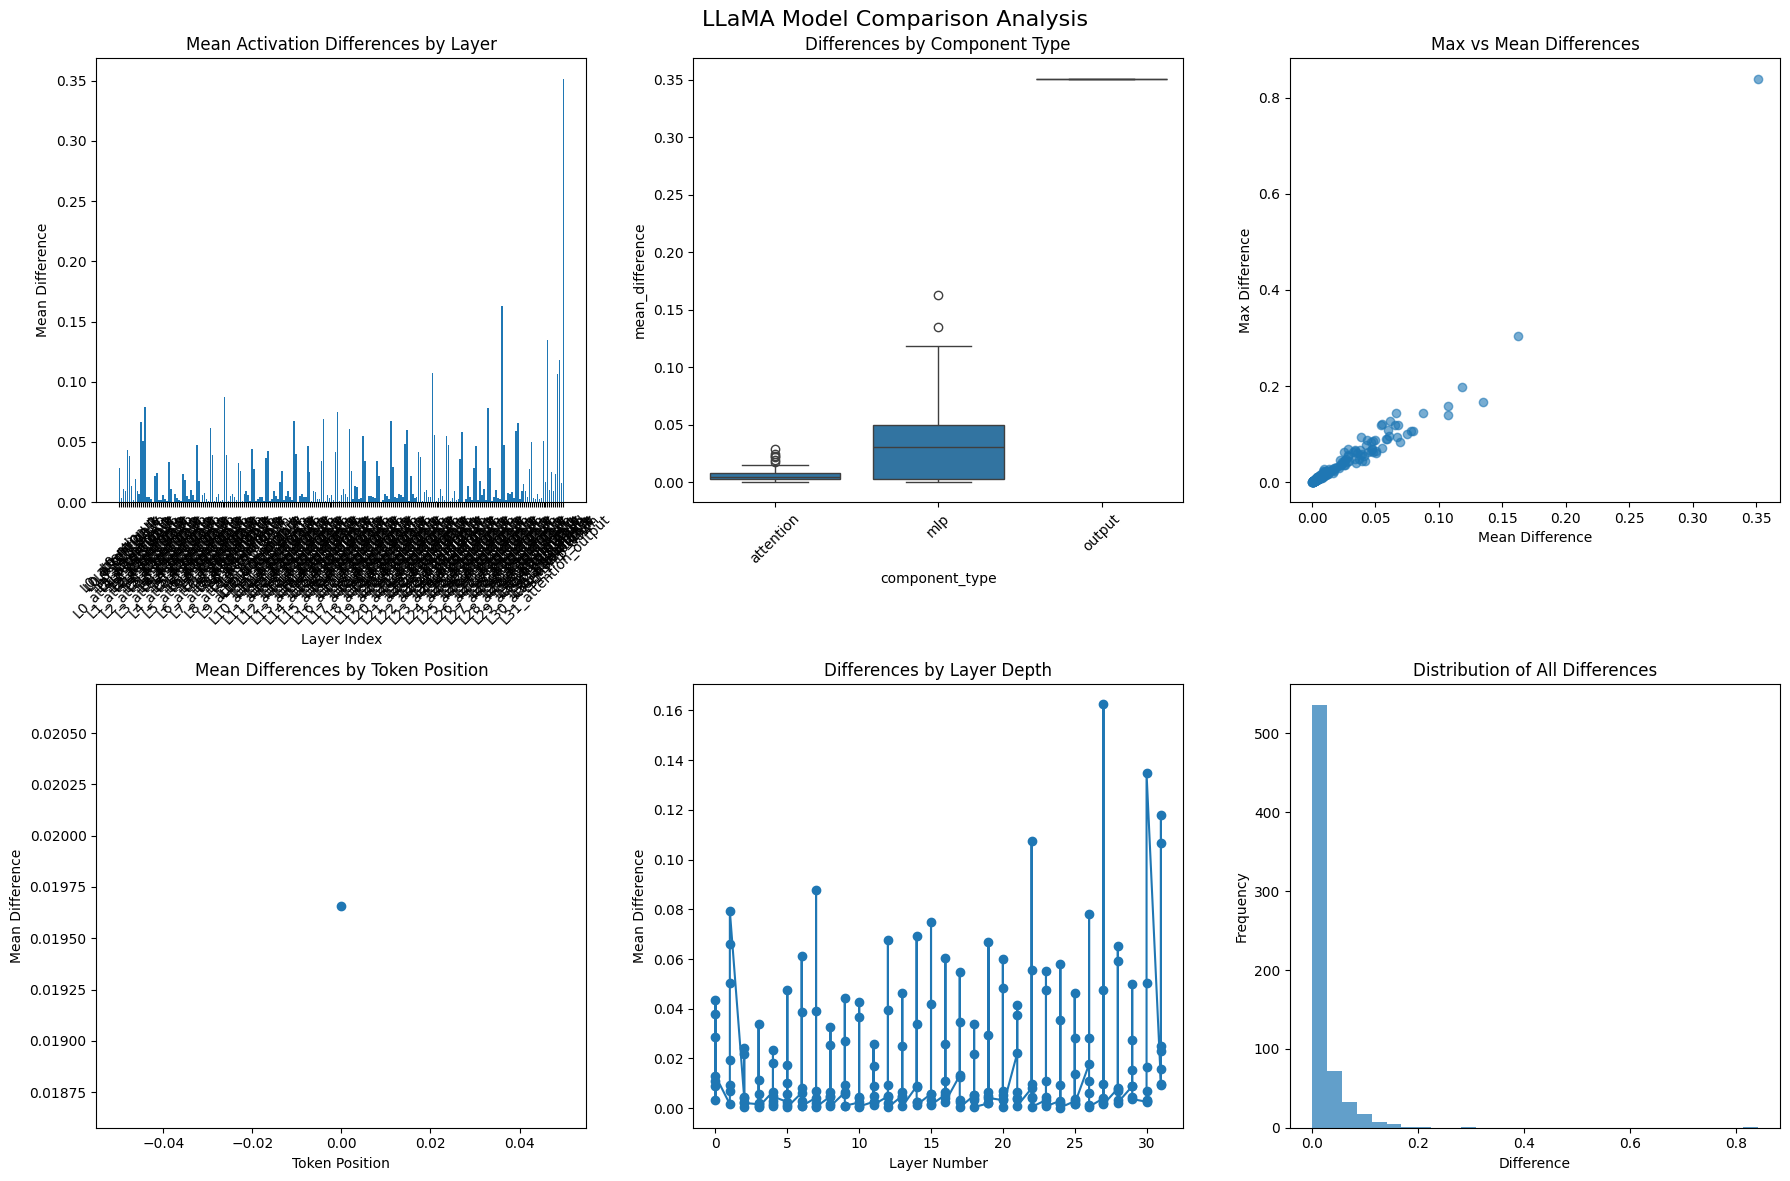

Completed text 1

=== Processing text 2/5 ===
Processing: Artificial intelligence is transforming the world ...
Input tokens: 13
Registering hooks...
Running models...
Captured 290 activations from Model 1
Captured 290 activations from Model 2
Valid activations - Model 1: 290, Model 2: 290
Selecting neurons...
Selected neurons from 290 layers
Comparing activations...
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
⚠️  layer_0_input_norm: No valid comparisons
✅ layer_0_attention_q: 3 neurons compared
✅ layer_0_attention_k: 3 neurons compared
✅ layer_0_attention_v: 3 neurons compared
✅ layer_0_attention_output: 3 neurons compared
Error calculating expected activation for layer_0_post_attn_norm: too many indices for tensor of 

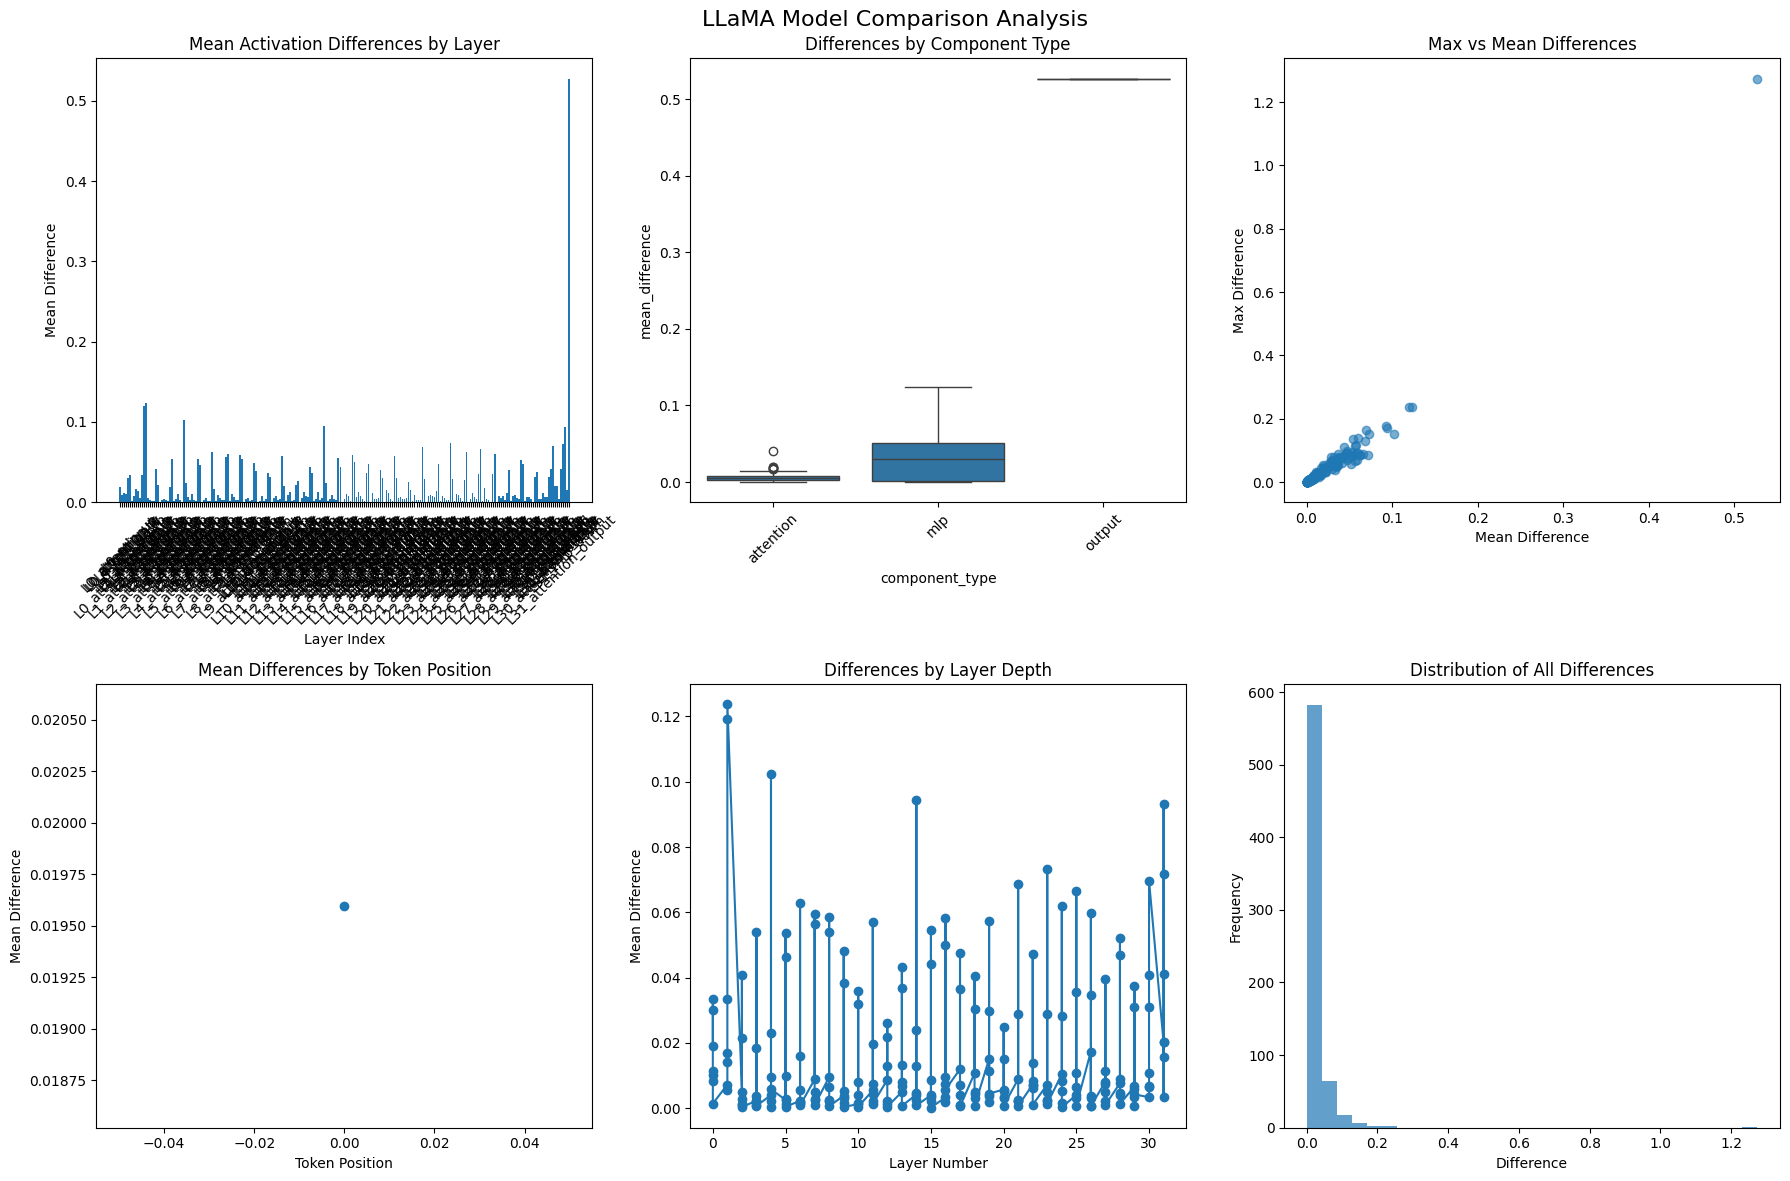

Completed text 2

=== Processing text 3/5 ===
Processing: In a hole in the ground there lived a hobbit....
Input tokens: 14
Registering hooks...
Running models...
Captured 290 activations from Model 1
Captured 290 activations from Model 2
Valid activations - Model 1: 290, Model 2: 290
Selecting neurons...
Selected neurons from 290 layers
Comparing activations...
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
⚠️  layer_0_input_norm: No valid comparisons
✅ layer_0_attention_q: 3 neurons compared
✅ layer_0_attention_k: 3 neurons compared
✅ layer_0_attention_v: 3 neurons compared
✅ layer_0_attention_output: 3 neurons compared
Error calculating expected activation for layer_0_post_attn_norm: too many indices for tensor of dimen

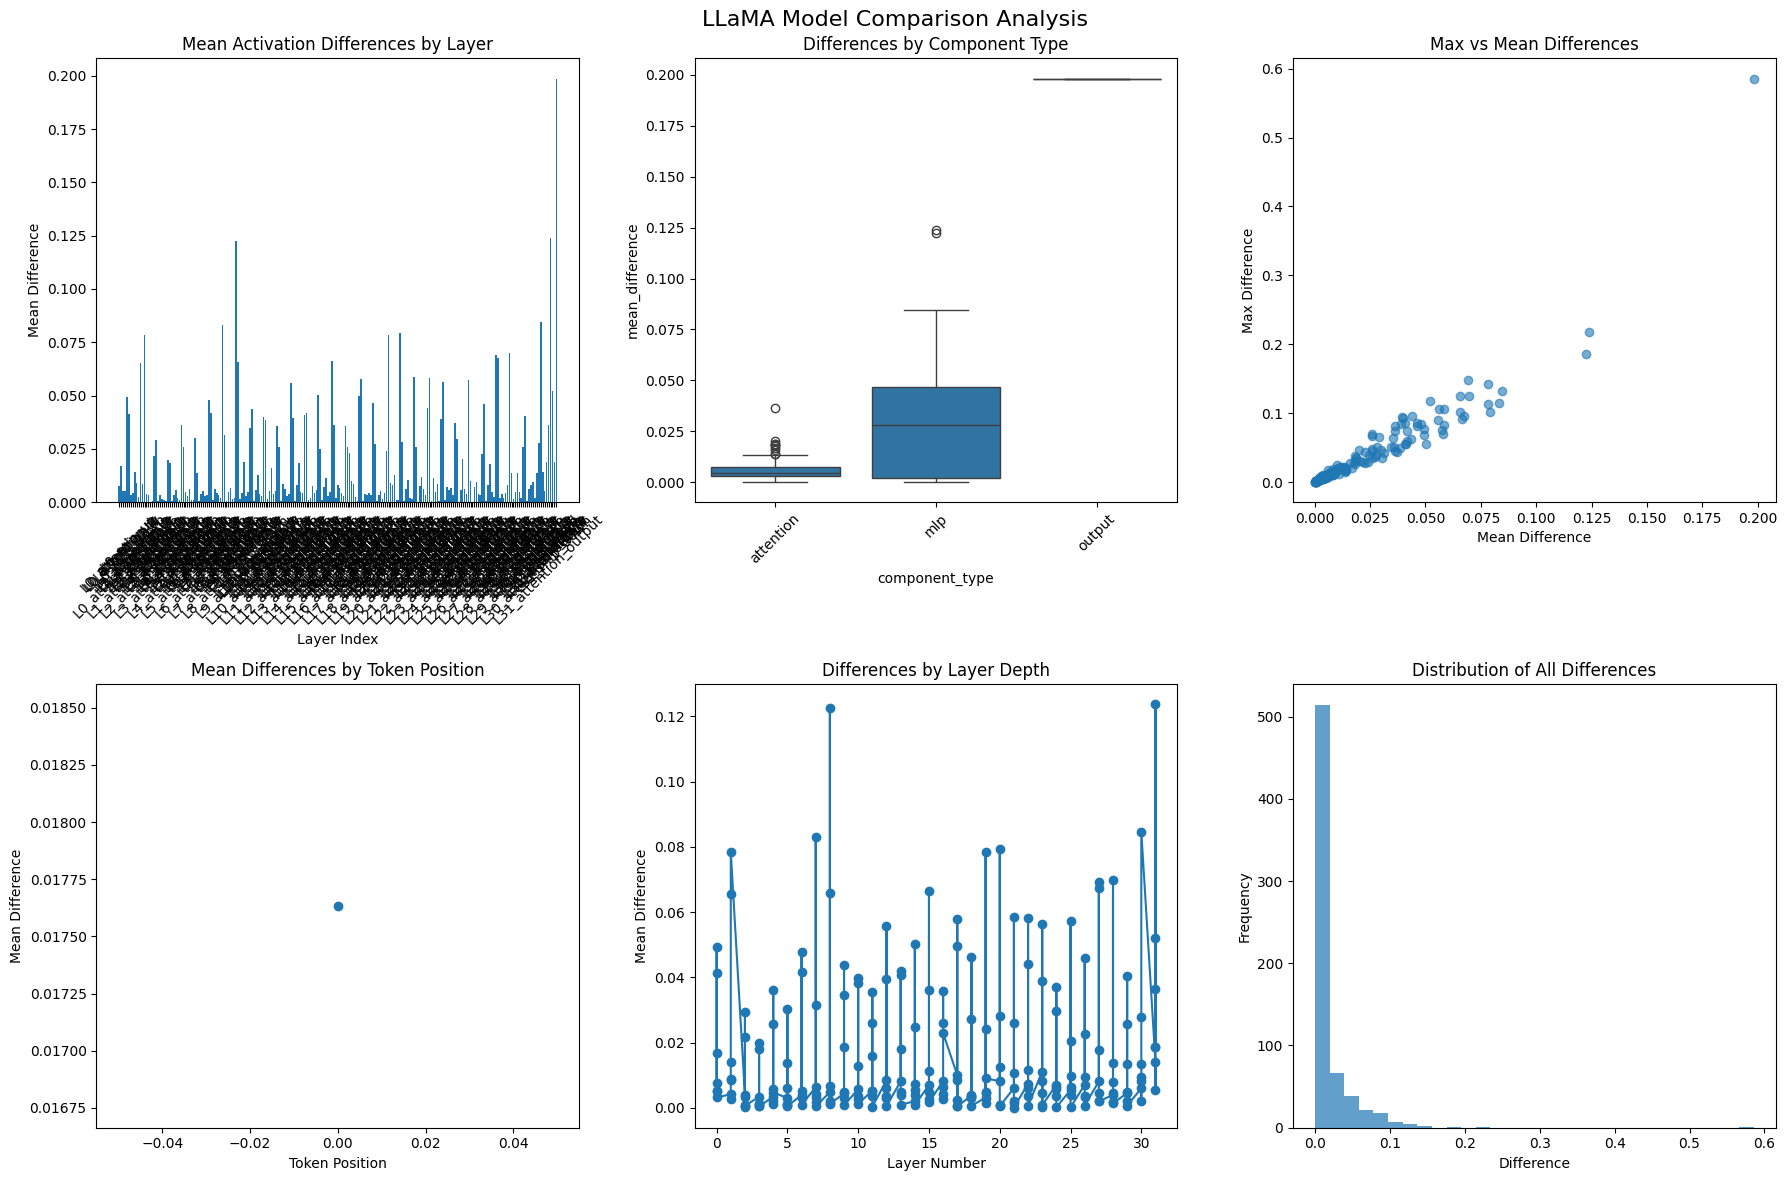

Completed text 3

=== Processing text 4/5 ===
Processing: To be or not to be, that is the question Shakespea...
Input tokens: 16
Registering hooks...
Running models...
Captured 290 activations from Model 1
Captured 290 activations from Model 2
Valid activations - Model 1: 290, Model 2: 290
Selecting neurons...
Selected neurons from 290 layers
Comparing activations...
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
⚠️  layer_0_input_norm: No valid comparisons
✅ layer_0_attention_q: 3 neurons compared
✅ layer_0_attention_k: 3 neurons compared
✅ layer_0_attention_v: 3 neurons compared
✅ layer_0_attention_output: 3 neurons compared
Error calculating expected activation for layer_0_post_attn_norm: too many indices for tensor of 

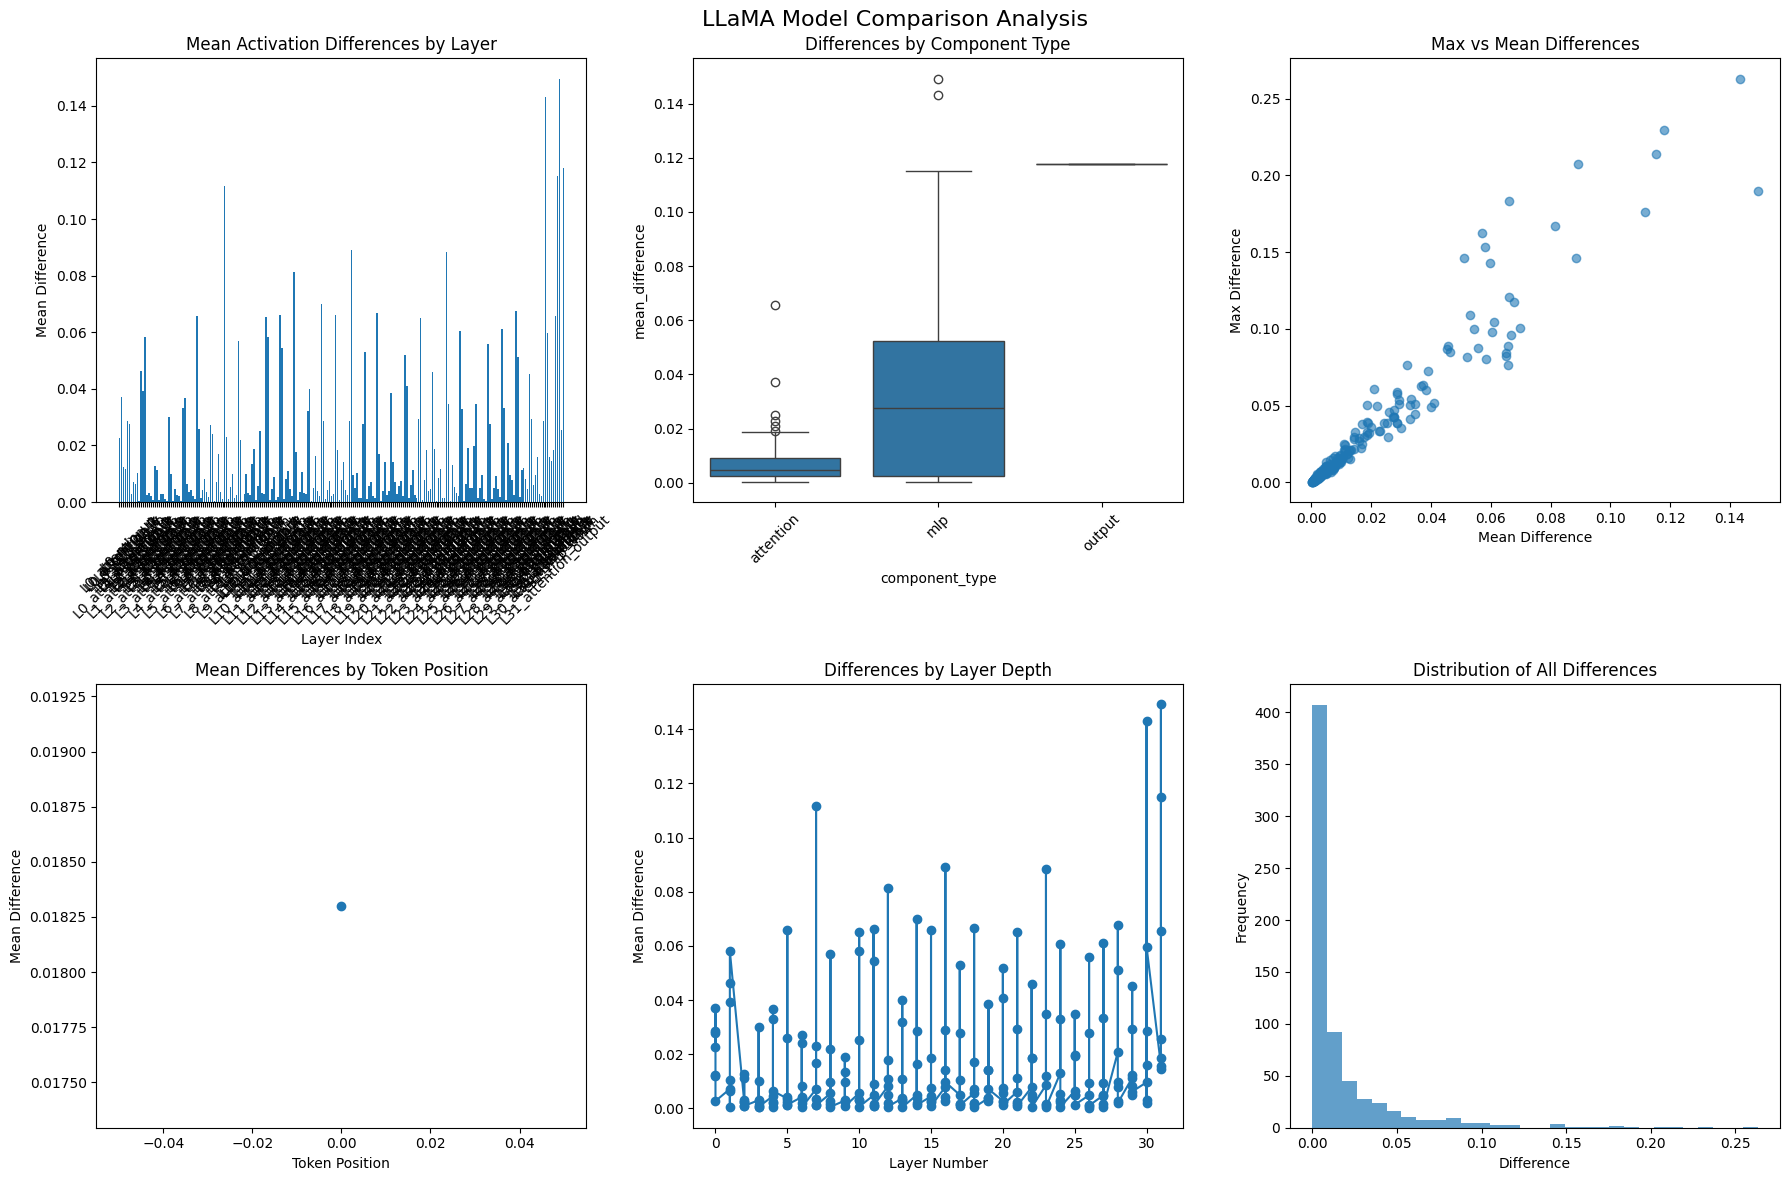

Completed text 4

=== Processing text 5/5 ===
Processing: Machine learning models require large datasets for...
Input tokens: 10
Registering hooks...
Running models...
Captured 290 activations from Model 1
Captured 290 activations from Model 2
Valid activations - Model 1: 290, Model 2: 290
Selecting neurons...
Selected neurons from 290 layers
Comparing activations...
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
Error calculating expected activation for layer_0_input_norm: too many indices for tensor of dimension 1
⚠️  layer_0_input_norm: No valid comparisons
✅ layer_0_attention_q: 3 neurons compared
✅ layer_0_attention_k: 3 neurons compared
✅ layer_0_attention_v: 3 neurons compared
✅ layer_0_attention_output: 3 neurons compared
Error calculating expected activation for layer_0_post_attn_norm: too many indices for tensor of 

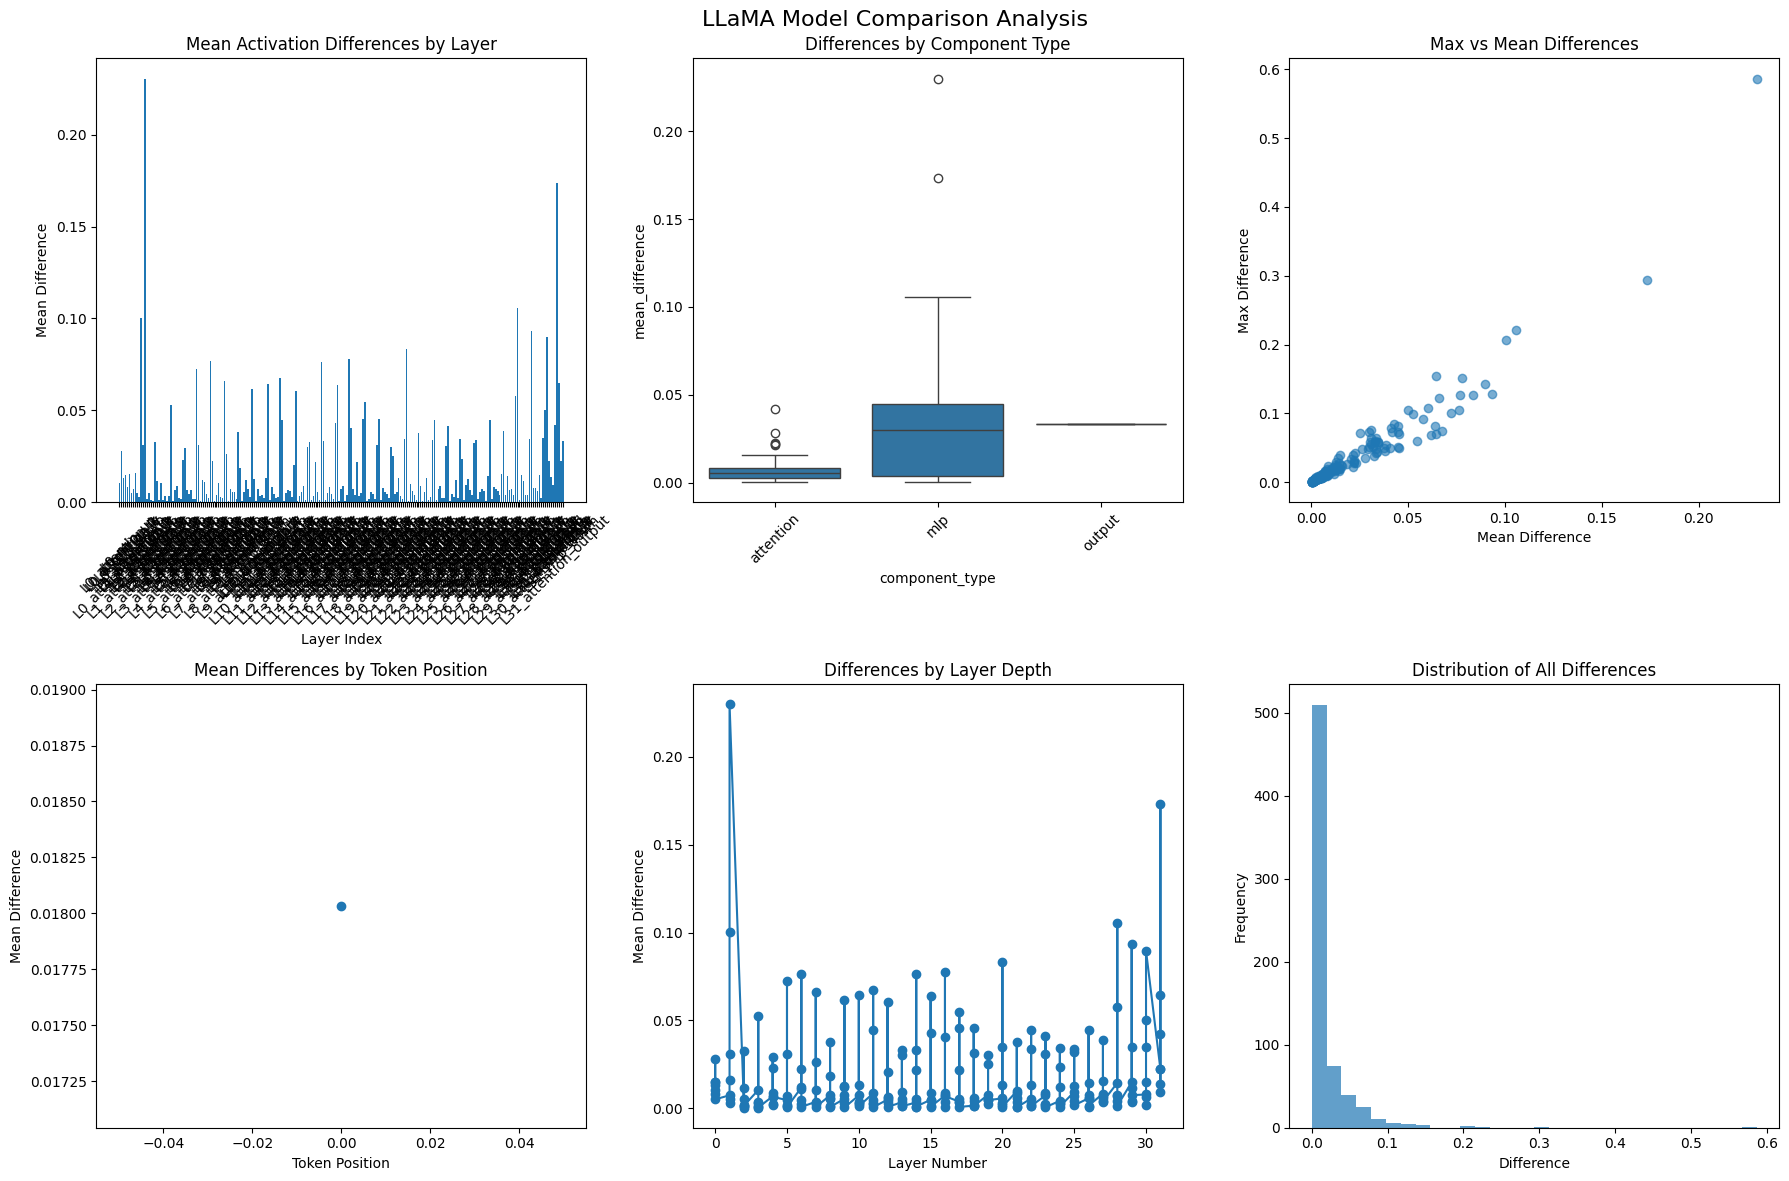

Completed text 5


In [21]:
results = []
all_results = []

for i, text in enumerate(TEST_TEXTS):
    print(f"\n=== Processing text {i+1}/{len(TEST_TEXTS)} ===")
    
    try:
        result = run_comparison(
            text,
            n_neurons=1,
            n_tokens=3,
            layer_range=None
        )
        
        all_results.append(result)
        
        # Save to CSV
        save_results_to_csv(result, input_id=i, filename="llama_comparison_results.csv")
        
        # Create visualization
        create_visualizations(result, save_path=f'llama_comparison_{i}.png')
        
        print(f"Completed text {i+1}")
        
    except Exception as e:
        print(f"Error processing text {i+1}: {e}")
        continue

In [22]:
if all_results:
    print("\n=== SUMMARY STATISTICS ===")
    
    all_layer_stats = defaultdict(list)
    all_component_stats = defaultdict(list)
    
    for result in all_results:
        for layer_name, layer_data in result['layer_comparisons'].items():
            if not np.isnan(layer_data['mean_difference']):
                all_layer_stats[layer_name].append(layer_data['mean_difference'])
                all_component_stats[layer_data['component_type']].append(layer_data['mean_difference'])
    
    print("Average differences by layer:")
    for layer, diffs in all_layer_stats.items():
        print(f"  {layer}: {np.mean(diffs):.6f} ± {np.std(diffs):.6f}")
    
    print("\nAverage differences by component type:")
    for component, diffs in all_component_stats.items():
        print(f"  {component}: {np.mean(diffs):.6f} ± {np.std(diffs):.6f}")


=== SUMMARY STATISTICS ===
Average differences by layer:
  layer_0_attention_q: 0.017667 ± 0.007757
  layer_0_attention_k: 0.018686 ± 0.012490
  layer_0_attention_v: 0.010626 ± 0.002833
  layer_0_attention_output: 0.010143 ± 0.003124
  layer_0_mlp_gate: 0.031892 ± 0.014303
  layer_0_mlp_up: 0.031142 ± 0.009195
  layer_0_mlp_down: 0.005074 ± 0.004139
  layer_1_attention_q: 0.005492 ± 0.002273
  layer_1_attention_k: 0.014476 ± 0.004410
  layer_1_attention_v: 0.009533 ± 0.002979
  layer_1_attention_output: 0.003763 ± 0.002376
  layer_1_mlp_gate: 0.062385 ± 0.022659
  layer_1_mlp_up: 0.049694 ± 0.037443
  layer_1_mlp_down: 0.113966 ± 0.061898
  layer_2_attention_q: 0.003583 ± 0.001227
  layer_2_attention_k: 0.003632 ± 0.000766
  layer_2_attention_v: 0.001529 ± 0.000862
  layer_2_attention_output: 0.000667 ± 0.000290
  layer_2_mlp_gate: 0.025949 ± 0.009758
  layer_2_mlp_up: 0.019501 ± 0.007081
  layer_2_mlp_down: 0.001112 ± 0.000590
  layer_3_attention_q: 0.004097 ± 0.003167
  layer_3_atte